In [151]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
def powerlaw(D, lamb, p0):
    x = np.arange(1,D) # D= max degree
    x = np.asarray(x, dtype=float)
    x = x**(-lamb)
    x = x/x.sum(axis=0)*(1-p0)
    x = np.insert(x, 0, p0, axis=0)
    return x

In [168]:
N_theory = 100 #number of nodes
D = N_theory-1 #maximum degree
lamb = 2.1
degree_seq = np.random.choice(np.arange(D), N_theory, replace=True, p=powerlaw(D,lamb, 0.0))
Gfull=nx.configuration_model(list(degree_seq))
Gfull=nx.Graph(Gfull)
Gfull.remove_edges_from(Gfull.selfloop_edges())

Gcc = sorted(nx.connected_component_subgraphs(Gfull), key=len, reverse=True)
G = Gcc[0]
N = len(G)
nodeset =  set(G.nodes())
print(N)

85


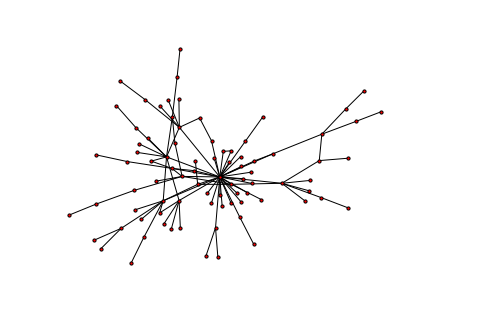

In [169]:
posit = nx.spring_layout(G)
nx.draw(G, pos=posit, node_size=10)

In [144]:
def simulate(Cmax, Cmin, thresh, seed, runtime, trialN):
    #vary coalition size

    degreelist = np.array(G.degree()).T[1]
    prob = degreelist/np.sum(degreelist)

    infectionsize = np.zeros([Cmax-Cmin+1, runtime])

    for trialnumber in range(trialN):
        initial_seed = set(np.random.choice(list(nodeset), int(seed*N), replace=False))
        for c in range(Cmin, Cmax):
            infected_nodes = initial_seed
            clean_nodes = nodeset - infected_nodes
            for t in range(runtime):
                infectionsize[c][t]= infectionsize[c][t] + len(infected_nodes)/N/trialN
                if len(infected_nodes) >=N:
                    infectionsize[c][range(t+1, runtime)] = infectionsize[c][range(t+1, runtime)] +  1/trialN
                    break
                coalition = set(np.random.choice(list(nodeset), c, replace=False, p = prob))
                neighset = set()
                for member in coalition:
                    neighset.update({n for n in G.neighbors(member)})
                neighset = neighset - coalition

                if len(infected_nodes.intersection(neighset)) >= thresh*len(neighset) :

                    infected_nodes.update(coalition)
                    clean_nodes = nodeset- infected_nodes


                else :
                    clean_nodes.update(coalition)
                    infected_nodes =nodeset- clean_nodes
    return infectionsize

In [145]:
def f(trialN):
    Cmax = 20
    Cmin = 1
    thresh = 0.5
    seed = 0.31
    runtime = N**2
    return simulate(Cmax, Cmin, thresh, seed, runtime, trialN)

In [170]:
pool= Pool()
results = pool.map(f, [2, 2, 2, 2])
infectionsize = np.asarray(sum(results), dtype=float)/4

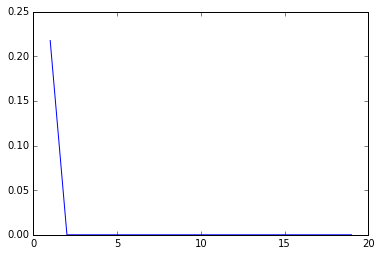

In [171]:
reverse = infectionsize.T
window = range(1,20)
plt.plot(window, reverse[runtime-1][window], 'b-')

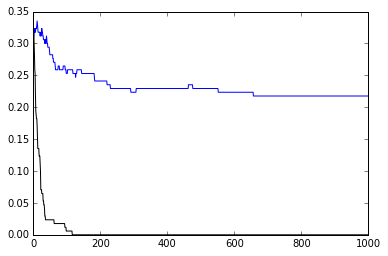

In [174]:
plt.plot(range(1000),infectionsize[1][range(1000)], 'b-', range(1000),infectionsize[7][range(1000)], 'k-')
#plt.ylim(0,1.01)

In [142]:
steps= N
convergence_rate = np.zeros([steps])
quart = 0.75
for s in range(Cmin, Cmax):
    time = np.where(infectionsize[s][range(runtime)]>quart)[0]
    if len(time) > 0:
        convergence_rate[s] = np.min(time)
    else:
        convergence_rate[s] = runtime
convergence_rate = convergence_rate/runtime
plt.loglog(range(1,11), convergence_rate[range(10)], 'b-')
plt.ylim(0,1)
plt.show()

/usr/lib/python3/dist-packages/matplotlib/transforms.py:2610: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
/usr/lib/python3/dist-packages/matplotlib/transforms.py:382: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


ValueError: cannot convert float NaN to integer